In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import scipy

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pylab import rcParams
from pandas.api.types import CategoricalDtype
from datetime import date, timedelta
import warnings
import folium
from folium.plugins import HeatMap
import pandas_profiling
import math
import seaborn as sns
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.1.3


In [3]:
from scipy.integrate import solve_ivp # to solve ODE system
from scipy import optimize # to solve minimization problem from least-squares fitting
from numba import jit # to accelerate ODE system RHS evaluations
import theano # to control better pymc3 backend and write a wrapper
import theano.tensor as t # for the wrapper to a custom model to pymc3

In [4]:
import pymc3 as pm # for uncertainty quantification and model calibration

# Plotting libs
import matplotlib.pyplot as plt
import altair as alt

seed = 12345 # for the sake of reproducibility :)
np.random.seed(seed)

THEANO_FLAGS='optimizer=fast_compile' # A theano trick

# Upload epi data

In [5]:
#df_covid = pd.read_csv("./italian_data.csv", parse_dates=['data']).drop('Unnamed: 0', axis=1).drop_duplicates()
df_covid = pd.read_csv("./italian_regional_data.csv", parse_dates=['data']).drop('Unnamed: 0', axis=1).drop_duplicates()

In [6]:
df_covid = df_covid[df_covid.denominazione_regione == 'Lombardia']

## Fix data

In [7]:
df_covid.rename(
    columns={
        'data': 'date', 
        'stato':'state',
        'totale_attualmente_positivi': 'confirmed',
        'deceduti':'deaths',
        'dimessi_guariti':'recovered'}, 
    inplace=True
)

# Upload population data

In [8]:
df_pop = pd.read_csv("./Italian_population_per_age.csv")

In [9]:
target_population = 10078012#df_pop.Population.sum()

In [10]:
df_covid.reset_index(drop=True).head()

,date,state,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,confirmed,nuovi_attualmente_positivi,recovered,deaths,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,3,Lombardia,45.466794,9.190347,76,19,95,71,166,166,0,6,172,1463
1,2020-02-25 18:00:00,ITA,3,Lombardia,45.466794,9.190347,79,25,104,127,231,65,0,9,240,3700
2,2020-02-26 18:00:00,ITA,3,Lombardia,45.466794,9.190347,79,25,104,145,249,18,0,9,258,3208
3,2020-02-27 18:00:00,ITA,3,Lombardia,45.466794,9.190347,172,41,213,136,349,100,40,14,403,3320
4,2020-02-28 18:00:00,ITA,3,Lombardia,45.466794,9.190347,235,47,282,192,474,125,40,17,531,4835


# Models

## initial conditions

In [11]:
df_target_country = df_covid.reset_index(drop=True)

In [12]:
S0, E0, A0, I0, R0, D0 = target_population, 5.*float(df_target_country.confirmed[0]),\
                        5.*float(df_target_country.confirmed[0]),\
                        float(df_target_country.confirmed[0]), float(df_target_country.recovered[0]),\
                        float(df_target_country.deaths[0])
y0_seird = S0 / target_population, E0/ target_population, A0 / target_population, I0 / target_population, \
           R0/ target_population, D0/ target_population  # SEIRD IC array

In [13]:
has_to_run_seird = True

In [14]:
data_time = np.arange(0, len(df_target_country.date.values), 1)
infected_individuals = df_target_country.confirmed.values / target_population
dead_individuals = df_target_country.deaths.values / target_population

In [15]:
@jit(nopython=True)
def infection_model(t, X, beta_I, beta_A, k_0, alpha, k, delta):
    """
    Variables:
    """
    gamma = 1.0/5.2 # 5.2 days is the incubation period
    mu_A = 1.0/2.3 # 2.3 days is the infectious period
    mu_I = 1.0/2.3 # 2.3 days is the infectious period
    #delta = 1.0 - (9. / 100.)
    #beta_A = prop*beta_I #Imperial College paper
    #####################
    S, E, A, I, R, D = X
    S_prime = - S * (beta_I * I + beta_A * A) - k_0 * S
    E_prime = S * (beta_I * I + beta_A * A) - (k_0 * E) - (gamma * E)
    A_prime = (alpha * gamma * E ) - (mu_A * A ) - (k_0 * A)
    I_prime = ((1. - alpha) * gamma * E) - (mu_I * I) - (k_0 * I) - (k * I)
    R_prime = (mu_A * A ) + delta * (mu_I * I)
    D_prime = (1.0 - delta) * (mu_I * I)
    return S_prime, E_prime, A_prime, I_prime, R_prime, D_prime

def seird_ode_solver(y0, t_span, t_eval, beta_I, beta_A, k_0, alpha, k, delta):
    solution_ODE = solve_ivp(
        fun=lambda t, y: infection_model(t, y, beta_I, beta_A, k_0, alpha, k, delta), 
        t_span=t_span, 
        y0=y0,
        t_eval=t_eval,
        method='LSODA'
    )
    return solution_ODE

def least_squares_error_ode(par, time_exp, f_exp, fitting_model, initial_conditions):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())
    
    y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    _, _, _, simulated_qoi1, _, simulated_qoi2 = simulated_ode_solution
    
    residual1 = f_exp1 - simulated_qoi1
    residual2 = f_exp2 - simulated_qoi2

    weighting_for_exp1_constraints = 1e0
    weighting_for_exp2_constraints = 1e0
    return weighting_for_exp1_constraints * np.sum(residual1 ** 2.0) + weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

def callback_de(xk, convergence):
    print(f'parameters = {xk}')

In [16]:
if has_to_run_seird:
    num_of_parameters_to_fit_sir = 6
    bounds_seird = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

    result_seird = optimize.differential_evolution(
        least_squares_error_ode, 
        bounds=bounds_seird, 
        args=(data_time, [infected_individuals, dead_individuals], seird_ode_solver, y0_seird), 
        popsize=1000,
        strategy='best1bin',
        tol=1e-2,
        recombination=0.7,
        mutation=0.7,
        maxiter=1000,
        disp=True,
        seed=seed,
        callback=callback_de,
        workers=-1
    )

    print(result_seird)

/Users/davide/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning:

differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'



differential_evolution step 1: f(x)= 1.01183e-05
parameters = [9.72497561e-01 7.51384729e-01 7.13001876e-04 2.48009720e-01
 2.83524585e-02 6.59678374e-01]
differential_evolution step 2: f(x)= 1.01183e-05
parameters = [9.72497561e-01 7.51384729e-01 7.13001876e-04 2.48009720e-01
 2.83524585e-02 6.59678374e-01]
differential_evolution step 3: f(x)= 1.01183e-05
parameters = [9.72497561e-01 7.51384729e-01 7.13001876e-04 2.48009720e-01
 2.83524585e-02 6.59678374e-01]
differential_evolution step 4: f(x)= 5.91407e-06
parameters = [0.95282158 0.83483934 0.00435122 0.08995769 0.00830969 0.84459405]
differential_evolution step 5: f(x)= 5.91407e-06
parameters = [0.95282158 0.83483934 0.00435122 0.08995769 0.00830969 0.84459405]
differential_evolution step 6: f(x)= 5.91407e-06
parameters = [0.95282158 0.83483934 0.00435122 0.08995769 0.00830969 0.84459405]
differential_evolution step 7: f(x)= 3.3282e-06
parameters = [0.99653509 0.94746318 0.00381166 0.1368593  0.01417187 0.88931873]
differential_evo

differential_evolution step 57: f(x)= 3.54999e-07
parameters = [9.99080876e-01 9.93346659e-01 2.33589605e-03 3.50922611e-04
 1.72580076e-03 9.47417293e-01]
differential_evolution step 58: f(x)= 3.54999e-07
parameters = [9.99080876e-01 9.93346659e-01 2.33589605e-03 3.50922611e-04
 1.72580076e-03 9.47417293e-01]
differential_evolution step 59: f(x)= 3.52155e-07
parameters = [9.98402573e-01 9.94343974e-01 2.21520240e-03 5.00451319e-03
 1.53679491e-04 9.45205625e-01]
differential_evolution step 60: f(x)= 3.50926e-07
parameters = [0.99940379 0.99940014 0.00224264 0.00441948 0.00101086 0.94952821]
differential_evolution step 61: f(x)= 3.50164e-07
parameters = [9.98687234e-01 9.98533816e-01 2.32425648e-03 5.77614494e-03
 2.89445644e-04 9.48297843e-01]
differential_evolution step 62: f(x)= 3.50164e-07
parameters = [9.98687234e-01 9.98533816e-01 2.32425648e-03 5.77614494e-03
 2.89445644e-04 9.48297843e-01]
differential_evolution step 63: f(x)= 3.50164e-07
parameters = [9.98687234e-01 9.98533816

differential_evolution step 110: f(x)= 3.41266e-07
parameters = [9.99967815e-01 9.99699321e-01 2.47834494e-03 2.90947193e-04
 1.60504890e-06 9.46277564e-01]
differential_evolution step 111: f(x)= 3.41266e-07
parameters = [9.99967815e-01 9.99699321e-01 2.47834494e-03 2.90947193e-04
 1.60504890e-06 9.46277564e-01]
differential_evolution step 112: f(x)= 3.41266e-07
parameters = [9.99967815e-01 9.99699321e-01 2.47834494e-03 2.90947193e-04
 1.60504890e-06 9.46277564e-01]
differential_evolution step 113: f(x)= 3.41122e-07
parameters = [9.99966088e-01 9.99920287e-01 2.45537346e-03 2.08548335e-04
 4.09363548e-05 9.47334717e-01]
differential_evolution step 114: f(x)= 3.41122e-07
parameters = [9.99966088e-01 9.99920287e-01 2.45537346e-03 2.08548335e-04
 4.09363548e-05 9.47334717e-01]
differential_evolution step 115: f(x)= 3.41122e-07
parameters = [9.99966088e-01 9.99920287e-01 2.45537346e-03 2.08548335e-04
 4.09363548e-05 9.47334717e-01]
differential_evolution step 116: f(x)= 3.41122e-07
paramet

In [17]:
beta_I_fitted, beta_A_fitted, k_0_fitted, alpha_fitted, k_fitted, delta_fitted = result_seird.x  # SEIRD parameters
print (result_seird.x)

[9.99966236e-01 9.99824444e-01 2.46325660e-03 8.73370466e-05
 3.91045529e-06 9.47427534e-01]


In [18]:
t0 = data_time.min()
tf = data_time.max()
print (t0, tf)

if has_to_run_seird:
    solution_ODE_seird = seird_ode_solver(y0_seird, (t0, tf), data_time, beta_I_fitted, beta_A_fitted, \
                                          k_0_fitted, alpha_fitted, k_fitted, delta_fitted)  # SEIRD
    t_computed_seird, y_computed_seird = solution_ODE_seird.t, solution_ODE_seird.y
    S_seird, E_seird, A_seird, I_seird, R_seird, D_seird = y_computed_seird
print (t_computed_seird)

0 28
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


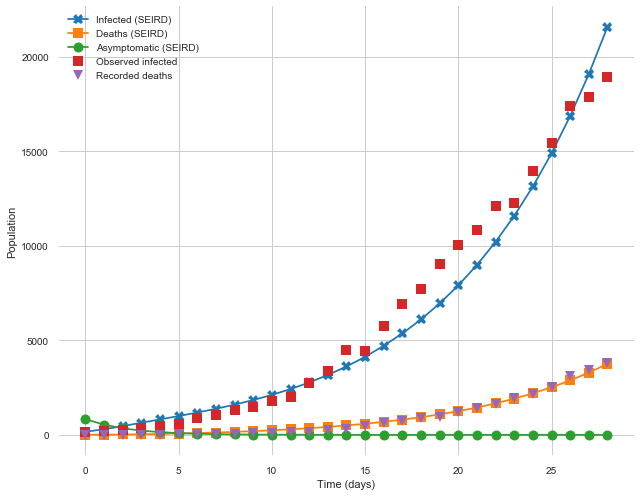

In [19]:
plt.figure(figsize=(9,7))
if has_to_run_seird:
    plt.plot(t_computed_seird, I_seird * target_population, label='Infected (SEIRD)', marker='X', linestyle="-", markersize=10)
    #plt.plot(t_computed_seird, R_seird * target_population, label='Recovered (SEIRD)', marker='o', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, D_seird * target_population, label='Deaths (SEIRD)', marker='s', linestyle="-", markersize=10)
    plt.plot(t_computed_seird, A_seird * target_population, label='Asymptomatic (SEIRD)', marker='o', linestyle="-", markersize=10)

plt.plot(data_time, infected_individuals * target_population, label='Observed infected', marker='s', linestyle="", markersize=10)
plt.plot(data_time, dead_individuals * target_population, label='Recorded deaths', marker='v', linestyle="", markersize=10)
plt.legend()
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Population')

plt.tight_layout()